# Dependencies

In [20]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import matplotlib

#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
pd.set_option('max_colwidth', 100)

<br>

# Functions

In [21]:
pd.read_csv("./cols_data_specs.csv").iloc[:,1:3]

variable  \
0          PC_CA-avg_3y   
1           REER-pch_1y   
2           REER-pch_3y   
3    X_G_share_M-pch_5y   
4   X_GS_share_M-pch_5y   
5    X_S_share_M-pch_5y   
6               FSL-mil   
7               FSL-pch   
8            FSL-pc_gdp   
9                GD-mil   
10            GD-pc_gdp   
11              HPI-pch   
12            HPI-index   
13             NIIP-mil   
14          NIIP-pc_gdp   
15           ULC-pch_3y   
16           ACT-pc_pop   
17           ACT-pch_3y   
18           LTU-pc_pop   
19           LTU-pch_3y   
20           YUR-pc_act   
21           YUR-pch_3y   
22             PSCF-mil   
23          PSCF-pc_gdp   
24              PSD-mil   
25           PSD-pc_gdp   
26            UR-avg_3y   

                                                                          description  
0                                            Current account balance - 3 year average  
1       Real effective exchange rate (42 trading partners based on HICP/CPI) - 1y pch  
2       Real effective exchange rate (42 trading partners based on HICP/CPI) - 3y pch  
3                                           G Export market shares - 5 years % change  
4                                          GS Export market shares - 5 years % change  
5                                           G Export market shares - 5 years % change  
6        Total financial sector liabilities non-consolidated - annual data - millions  
7       Total financial sector liabilities non-consolidated - annual data - 1y change  
8          Total financial sector liabilities non-consolidated - annual data - pc gdp  
9   General government gross debt (EDP concept) consolidated - annual data - millions  
10    General government gross debt (EDP concept) consolidated - annual data - pc gdp  
11                                    House price index deflated - annual data - pch   
12                                   House price index deflated - annual data - index  
13                     Net international investment position - annual data - millions  
14                       Net international investment position - annual data - pc gdp  
15                                        Nominal unit labour cost - 3 years % change  
16                          Activity rate - % of total population aged 15-64 - pc pop  
17                          Activity rate - % of total population aged 15-64 - pch 3y  
18             Long-term unemployment rate % of active population aged 15-74 - pc pop  
19             Long-term unemployment rate % of active population aged 15-74 - pch 3y  
20               Youth unemployment rate - % of active population aged 15-24 - pc act  
21               Youth unemployment rate - % of active population aged 15-24 - pch 3y  
22                         Private sector credit flow consolidated - % GDP - millions  
23                           Private sector credit flow consolidated - % GDP - pc gdp  
24                             Private sector debt consolidated - % of GDP - millions  
25                               Private sector debt consolidated - % of GDP - pc gdp  
26                                                 Unemployment rate - 3 year average

In [2]:
def dataset_preproc():
    
    data_description = pd.read_csv("./cols_data_specs.csv")
    data_col_fixed   = ['label']; data_col_fixed.extend(data_description.sort_values("specification").iloc[:,1])
    data = pd.read_csv("./data.csv", index_col=0)
    data = data[sorted(data.columns)]
    data.columns = data_col_fixed
    data = data[["label"]+list(data_description[data_description.type_var == "headline"].variable.values)]
    data.loc[data.label == 0,["label"]] = 1
    data.to_csv("./dataset.csv")
    
    return(data, data_description, dict(zip(list(data_description.variable),list(data_description.description))))

In [3]:
def ADASYN_res(X,y):
    
    sm = ADASYN(sampling_strategy="all", n_neighbors=3)
    X_train_res, y_train_res = sm.fit_sample(X, y)
    
    return(X_train_res, y_train_res)

In [4]:
def average_accuracies(X,y,depth_max, times_max, thresh=False):
    
    df = pd.DataFrame({"Depth": range(1,depth_max+1)})
    df_train = pd.DataFrame({"Depth": range(1,depth_max+1)})
    for time in range(1,1+times_max):
        cv = StratifiedKFold(n_splits=5, shuffle=True)
        accuracies = list()
        accuracies_train = list()
        for depth in range(1,depth_max+1):
            fold_accuracy = []
            fold_accuracy_train = []
            for (train, test), i in zip(cv.split(X, y), range(5)):
                X_train_res, y_train_res = ADASYN_res(X.iloc[train],y.iloc[train])
                X_train_res, X_test = pd.DataFrame(X_train_res, columns=X.columns), pd.DataFrame(X.iloc[test], columns=X.columns)
                if thresh == True:
                    X_train_res = thresh_maker(X_train_res)
                    X_test = thresh_maker(X_test)
                y_pred = RandomForestClassifier(max_depth = depth, n_estimators=100).\
                                                fit(X_train_res, y_train_res).predict(X_test)
                fold_accuracy.append(accuracy_score(y.iloc[test], y_pred))
                y_pred_train = RandomForestClassifier(max_depth = depth, 
                                                                           n_estimators=100).\
                                                    fit(X_train_res, y_train_res).predict(X_train_res)
                fold_accuracy_train.append(accuracy_score(y_train_res,y_pred_train))
            
            avg = sum(fold_accuracy)/len(fold_accuracy)
            avg_train = sum(fold_accuracy_train)/len(fold_accuracy_train)
            accuracies.append(avg)
            accuracies_train.append(avg_train)
        df["Run %s" % time] = accuracies
        df_train["Run %s" % time] = accuracies_train
        
    df = df.set_index("Depth")
    df_train = df_train.set_index("Depth")
    df["Average Accuracy"] = df.mean(axis=1)
    df_train["Average Accuracy"] = df_train.mean(axis=1)
    
    plt.subplots(figsize=(10,5))
    plt.plot(df.index,df_train[["Average Accuracy"]], color="k", linestyle="--")
    plt.plot(df.index,df[["Average Accuracy"]], color="k")
    plt.ylabel("Accuracy")
    plt.xlabel("Depth")
    plt.legend(["Train", "Test"])
    plt.grid()
    for frmt in ['png', 'pdf']: plt.savefig("./materials/depth_accuracy"+['.','_cat.'][int(thresh)]+frmt, bbox_inches='tight', transparent=True)
    plt.show()
    
    return(df, df_train)

In [5]:
def model_preproc(X, y):
    
    print("Categories in the entire set:")
    print(pd.Series(y).value_counts().sort_index(), "\n") 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)# , random_state=0
    print("Categories in the test set:")
    print(pd.Series(y_test).value_counts().sort_index(), "\n")   
    print("Categories in the train set before ADASYN method:")
    print(pd.Series(y_train).value_counts().sort_index(), "\n")
    
    X_train_res, y_train_res = ADASYN_res(X_train,y_train)
    print("Categories in the train set after ADASYN method:")
    print(pd.Series(y_train_res).value_counts().sort_index(), "\n")
    
    assert True not in pd.DataFrame(X_train_res, columns=X_test.columns).append(X_test).duplicated().value_counts().index, "There is bleeding!"
    
    return(X_train_res, y_train_res, X_test, y_test)

In [6]:
def thresh_maker(df):
    
    df_thresh = df.copy(); df_thresh.iloc[:,:] = 0
    for var in df.columns:
        df_thresh.loc[df[var]>data_description.loc[data_description.variable == var, ["thresh_above1"]].values[0][0],[var]] = 1
        df_thresh.loc[df[var]>data_description.thresh_above2[0],[var]] = 2
        
    return(df_thresh)

In [7]:
def model(X, y, preproc, depth=4, trees=100, thresh=False):
    
    X_train_res, y_train_res, X_test, y_test = preproc(X, y)
    X_train_res, X_test = pd.DataFrame(X_train_res, columns=X_test.columns), pd.DataFrame(X_test, columns=X_test.columns)
    
    if thresh == True:
        X_train_res = thresh_maker(X_train_res)
        X_test = thresh_maker(X_test)
    
    rf = RandomForestClassifier(max_depth = depth, n_estimators=trees).fit(X_train_res, y_train_res)
    y_pred = rf.predict(X_test)
    
    train, test = X_train_res.copy(), X_test.copy()
    train["label"] = pd.Series(y_train_res)
    test["label"] = y_test
    test["pred"] = y_pred
    
    print("Accuracy with a depth of %s and %s trees:" % (depth, trees))
    print(accuracy_score(y_test, y_pred), "\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred),"\n")
    
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion matrix:')
    print(conf_mat, "\n")
    
    labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.binary)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    for frmt in ['png', 'pdf']: plt.savefig(f'./materials/confusion_matrix.{frmt}', bbox_inches='tight', transparent=True)
    plt.show()
    print("\n")
    
    featureimportance = pd.DataFrame(rf.feature_importances_, X.columns.values, columns=["Importance"]).rename_axis('Feature').sort_values("Importance", ascending=True)
    featureimportance["Definition"] = featureimportance.index.map(variable_definition)      
    print("Feature importance in the model:")
    print(featureimportance.sort_values("Importance", ascending=False)[["Definition", "Importance"]].to_string(),"\n")
    
    f, ax = plt.subplots(figsize=(5,10))
    plt.barh([i.replace("_", "\\_") for i in featureimportance.index.values], featureimportance.Importance, color="k")
    for frmt in ['png', 'pdf']: f.savefig(f'materials/feature_importance.{frmt}', bbox_inches='tight', transparent=True)
    ax.xaxis.grid(True)

    return(rf, train, test, 
           [featureimportance.sort_values("Importance", ascending=False)[["Definition", "Importance"]], 
            pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()])

<br>

# Data

In [8]:
data, data_description, variable_definition = dataset_preproc()
X,y = data.iloc[:,1:], data.iloc[:,0]

In [9]:
data_description.to_csv('materials/data_description.csv')
data_description

specification             variable  \
0        tipsbp10-PC_GDP_3Y-NSA-CA-BAL-WRL_REST         PC_CA-avg_3y   
1                               tipser10-PCH_1Y          REER-pch_1y   
2                               tipser10-PCH_3Y          REER-pch_3y   
3            tipsex10-PCH_WRL_5Y-G-CRE-WRL_REST   X_G_share_M-pch_5y   
4           tipsex10-PCH_WRL_5Y-GS-CRE-WRL_REST  X_GS_share_M-pch_5y   
5            tipsex10-PCH_WRL_5Y-S-CRE-WRL_REST   X_S_share_M-pch_5y   
6               tipsfs10-F-NCO-S12-LIAB-MIO_NAC              FSL-mil   
7               tipsfs10-F-NCO-S12-LIAB-PCH_PRE              FSL-pch   
8                tipsfs10-F-NCO-S12-LIAB-PC_GDP           FSL-pc_gdp   
9                       tipsgo10-GD-S13-MIO_NAC               GD-mil   
10                       tipsgo10-GD-S13-PC_GDP            GD-pc_gdp   
11                           tipsho10-INX_A_AVG              HPI-pch   
12                           tipsho10-RCH_A_AVG            HPI-index   
13  tipsii10-NSA-FA-S1-S1-N_LE-WRL_REST-MIO_NAC             NIIP-mil   
14   tipsii10-NSA-FA-S1-S1-N_LE-WRL_REST-PC_GDP          NIIP-pc_gdp   
15                     tipslm10-NULC_PER-PCH_3Y           ULC-pch_3y   
16                            tipslm60-T-PC_POP           ACT-pc_pop   
17                           tipslm60-T-PPCH_3Y           ACT-pch_3y   
18                            tipslm70-PC_ACT-T           LTU-pc_pop   
19                           tipslm70-PPCH_3Y-T           LTU-pch_3y   
20                     tipslm80-Y_LT25-T-PC_ACT           YUR-pc_act   
21                    tipslm80-Y_LT25-T-PPCH_3Y           YUR-pch_3y   
22   tipspc20-CO-S11_S14_S15-LIAB-F3_F4-MIO_NAC             PSCF-mil   
23    tipspc20-CO-S11_S14_S15-LIAB-F3_F4-PC_GDP          PSCF-pc_gdp   
24   tipspd20-CO-S11_S14_S15-LIAB-F3_F4-MIO_NAC              PSD-mil   
25    tipspd20-CO-S11_S14_S15-LIAB-F3_F4-PC_GDP           PSD-pc_gdp   
26                      tipsun10-TOTAL-AVG_3Y-T            UR-avg_3y   

                                          description   type_var  \
0            Current account balance - 3 year average   headline   
1   Real effective exchange rate (42 trading partn...  auxiliary   
2   Real effective exchange rate (42 trading partn...   headline   
3           G Export market shares - 5 years % change  auxiliary   
4          GS Export market shares - 5 years % change   headline   
5           G Export market shares - 5 years % change  auxiliary   
6   Total financial sector liabilities non-consoli...  auxiliary   
7   Total financial sector liabilities non-consoli...   headline   
8   Total financial sector liabilities non-consoli...  auxiliary   
9   General government gross debt (EDP concept) co...  auxiliary   
10  General government gross debt (EDP concept) co...   headline   
11    House price index deflated - annual data - pch    headline   
12   House price index deflated - annual data - index  auxiliary   
13  Net international investment position - annual...  auxiliary   
14  Net international investment position - annual...   headline   
15        Nominal unit labour cost - 3 years % change   headline   
16  Activity rate - % of total population aged 15-...  auxiliary   
17  Activity rate - % of total population aged 15-...   headline   
18  Long-term unemployment rate % of active popula...  auxiliary   
19  Long-term unemployment rate % of active popula...   headline   
20  Youth unemployment rate - % of active populati...  auxiliary   
21  Youth unemployment rate - % of active populati...   headline   
22  Private sector credit flow consolidated - % GD...  auxiliary   
23  Private sector credit flow consolidated - % GD...   headline   
24  Private sector debt consolidated - % of GDP - ...  auxiliary   
25  Private sector debt consolidated - % of GDP - ...   headline   
26                 Unemployment rate - 3 year average   headline   

    thresh_above1  thresh_above2  thresh_above1_NEA  thresh_above2_NEA  
0            -4.0            6.0       

In [10]:
data.iloc[(np.r_[0:6, -6:0])]

label  PC_CA-avg_3y  REER-pch_3y  X_GS_share_M-pch_5y  FSL-pch  \
2011_AT      1           2.4         -1.8               -12.46      1.5   
2011_BE      2          -0.1         -1.5                -7.63      5.4   
2011_CZ      1          -2.6         -0.5                 7.43      4.3   
2011_DE      1           5.9         -4.9                -9.31      2.9   
2011_DK      2           5.5         -2.5               -13.74      1.6   
2011_EE      1           1.9         -0.8                24.30     -0.2   
2017_PT      2           0.4         -0.8                14.29      1.9   
2017_RO      1          -2.2         -5.6                36.63      8.1   
2017_SE      2           3.6         -5.5                -4.47      6.8   
2017_SI      1           4.9         -2.1                18.19      5.1   
2017_SK      1          -2.0         -2.1                 6.35     17.9   
2017_UK      1          -4.5        -10.8                -1.27     -1.7   

         GD-pc_gdp  HPI-pch  NIIP-pc_gdp  ULC-pch_3y  ACT-pch_3y  LTU-pch_3y  \
2011_AT       82.4    88.41         -1.9         5.8         0.7         0.2   
2011_BE      102.6    99.49         60.9         5.3        -0.4         0.2   
2011_CZ       39.8    98.86        -45.2         3.4         0.8         0.5   
2011_DE       79.4    90.32         23.2         5.7         1.4        -1.1   
2011_DK       46.1    92.83         27.8         3.6        -1.4         1.3   
2011_EE        6.1    74.86        -54.8        -2.6         0.5         5.4   
2017_PT      124.8   114.39       -104.9         3.5         1.5        -3.9   
2017_RO       35.2   108.67        -47.8        13.5         1.6        -0.8   
2017_SE       40.8   112.54          4.4         3.8         1.0        -0.2   
2017_SI       74.1   110.24        -24.2         3.4         3.3        -2.2   
2017_SK       50.9   111.76        -65.6         6.9         1.8        -4.2   
2017_UK       87.1   107.92         -8.1         5.3         0.9        -1.1   

         YUR-pch_3y  PSCF-pc_gdp  PSD-pc_gdp  UR-avg_3y  
2011_AT         0.4          3.0       129.4        4.9  
2011_BE         0.7         21.7       181.5        7.8  
2011_CZ         8.2          2.1        68.3        6.9  
2011_DE        -1.9          1.6       102.5        6.8  
2011_DK         6.2          4.4       221.0        7.0  
2011_EE        10.4         -1.1       120.4       14.2  
2017_PT       -10.9          2.0       163.0       10.9  
2017_RO        -5.7          1.7        51.0        5.9  
2017_SE        -5.1         13.1       195.6        7.0  
2017_SI        -9.0          0.8        75.6        7.9  
2017_SK       -10.8          5.9        96.1        9.8  
2017_UK        -4.9          8.2       171.5        4.8

In [11]:
data.describe()

label  PC_CA-avg_3y  REER-pch_3y  X_GS_share_M-pch_5y     FSL-pch  \
count  191.000000    191.000000   191.000000           191.000000  191.000000   
mean     1.863874      0.651832    -1.909424            -1.257435    3.656021   
std      0.958235      3.806225     3.768095            16.496286    7.386913   
min      1.000000    -11.200000   -12.200000           -31.670000  -17.600000   
25%      1.000000     -1.600000    -4.000000           -12.905000   -0.100000   
50%      2.000000      0.100000    -1.800000            -3.260000    3.300000   
75%      2.000000      2.400000     0.100000             7.565000    6.950000   
max      4.000000      9.500000    10.700000            71.490000   45.800000   

        GD-pc_gdp     HPI-pch  NIIP-pc_gdp  ULC-pch_3y  ACT-pch_3y  \
count  191.000000  191.000000   191.000000  191.000000  191.000000   
mean    70.231414  100.629372   -35.754450    2.784817    1.114136   
std     36.852599    9.086631    57.602867    6.492524    1.406810   
min      6.100000   74.860000  -198.700000  -21.000000   -3.600000   
25%     40.850000   95.845000   -67.550000   -0.150000    0.300000   
50%     67.700000  100.000000   -39.600000    3.100000    0.900000   
75%     89.250000  105.490000     3.700000    6.150000    1.750000   
max    178.900000  136.510000    64.500000   17.800000    6.000000   

       LTU-pch_3y  YUR-pch_3y  PSCF-pc_gdp  PSD-pc_gdp   UR-avg_3y  
count  191.000000  191.000000   191.000000  191.000000  191.000000  
mean     0.317801   -0.379058     2.626178  147.741885   10.052356  
std      2.761559    8.198375     6.667711   72.904546    4.766747  
min     -5.500000  -18.100000   -15.700000   51.000000    4.000000  
25%     -1.100000   -5.800000    -0.800000   96.800000    6.800000  
50%      0.100000   -0.900000     2.100000  125.100000    8.500000  
75%      1.150000    3.150000     4.850000  187.600000   12.200000  
max     12.800000   29.600000    29.500000  353.500000   26.300000

<br>

# Depth Choice

## Continuous

averages, averages_train = average_accuracies(X,y,10,10, False)

averages_train.to_csv('materials/avg_train_accuracy.csv')
averages_train

averages.to_csv('materials/avg_test_accuracy.csv')
averages

# Categories

averages_cat, averages_train_cat = average_accuracies(X,y,10,10, True)

averages_train_cat.to_csv('materials/avg_train_accuracy_cat.csv')
averages_cat.to_csv('materials/avg_test_accuracy_cat.csv')

<br>

# Model

Categories in the entire set:
1    85
2    64
3    25
4    17
Name: label, dtype: int64 

Categories in the test set:
1    17
2    13
3     5
4     4
Name: label, dtype: int64 

Categories in the train set before ADASYN method:
1    68
2    51
3    20
4    13
Name: label, dtype: int64 

Categories in the train set after ADASYN method:
1    68
2    67
3    68
4    65
dtype: int64 

Accuracy with a depth of 4 and 100 trees:
0.6410256410256411 

Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.71      0.75        17
           2       0.78      0.54      0.64        13
           3       0.33      0.60      0.43         5
           4       0.50      0.75      0.60         4

    accuracy                           0.64        39
   macro avg       0.60      0.65      0.60        39
weighted avg       0.70      0.64      0.66        39
 

Confusion matrix:
[[12  1  3  1]
 [ 3  7  2  1]
 [ 0  1  3  1]
 [ 0  0  1  3]] 



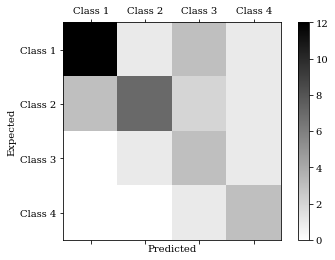



Feature importance in the model:
                                                            Definition  Importance
Feature                                                                           
UR-avg_3y                           Unemployment rate - 3 year average    0.147467
NIIP-pc_gdp          Net international investment position - annual...    0.136090
PC_CA-avg_3y                  Current account balance - 3 year average    0.118754
YUR-pch_3y           Youth unemployment rate - % of active populati...    0.098703
LTU-pch_3y           Long-term unemployment rate % of active popula...    0.079429
GD-pc_gdp            General government gross debt (EDP concept) co...    0.071851
PSD-pc_gdp           Private sector debt consolidated - % of GDP - ...    0.065245
X_GS_share_M-pch_5y         GS Export market shares - 5 years % change    0.063615
ACT-pch_3y           Activity rate - % of total population aged 15-...    0.049327
FSL-pch              Total financial sector liabilit

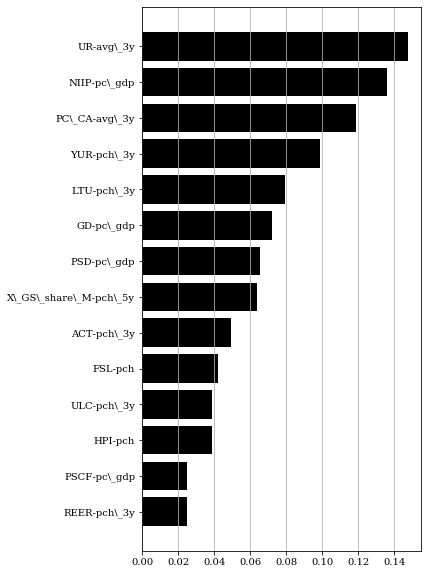

In [12]:
rf, train, test, tables = model(X,y, model_preproc, 4, 100, thresh=False)
for i in ['materials', 'model']: train.to_csv(f"./{i}/train.csv", index=False)
for i in ['materials', 'model']: test.to_csv(f"./{i}/test.csv", index=False)

In [13]:
tables[0].to_csv('./materials/feature_importance.csv')
tables[0]

Definition  \
Feature                                                                  
UR-avg_3y                           Unemployment rate - 3 year average   
NIIP-pc_gdp          Net international investment position - annual...   
PC_CA-avg_3y                  Current account balance - 3 year average   
YUR-pch_3y           Youth unemployment rate - % of active populati...   
LTU-pch_3y           Long-term unemployment rate % of active popula...   
GD-pc_gdp            General government gross debt (EDP concept) co...   
PSD-pc_gdp           Private sector debt consolidated - % of GDP - ...   
X_GS_share_M-pch_5y         GS Export market shares - 5 years % change   
ACT-pch_3y           Activity rate - % of total population aged 15-...   
FSL-pch              Total financial sector liabilities non-consoli...   
ULC-pch_3y                 Nominal unit labour cost - 3 years % change   
HPI-pch                House price index deflated - annual data - pch    
PSCF-pc_gdp          Private sector credit flow consolidated - % GD...   
REER-pch_3y          Real effective exchange rate (42 trading partn...   

                     Importance  
Feature                          
UR-avg_3y              0.147467  
NIIP-pc_gdp            0.136090  
PC_CA-avg_3y           0.118754  
YUR-pch_3y             0.098703  
LTU-pch_3y             0.079429  
GD-pc_gdp              0.071851  
PSD-pc_gdp             0.065245  
X_GS_share_M-pch_5y    0.063615  
ACT-pch_3y             0.049327  
FSL-pch                0.042187  
ULC-pch_3y             0.038759  
HPI-pch                0.038521  
PSCF-pc_gdp            0.025076  
REER-pch_3y            0.024976

In [14]:
tables[1].to_csv('./materials/classification_report.csv');
tables[1]

precision    recall  f1-score    support
1              0.800000  0.705882  0.750000  17.000000
2              0.777778  0.538462  0.636364  13.000000
3              0.333333  0.600000  0.428571   5.000000
4              0.500000  0.750000  0.600000   4.000000
accuracy       0.641026  0.641026  0.641026   0.641026
macro avg      0.602778  0.648586  0.603734  39.000000
weighted avg   0.701994  0.641026  0.655528  39.000000

<br>

# Interesting

The only countries wrongly classified in the ```test``` were:


In [15]:
test[(test.label==2)&(test.pred!=2)]

PC_CA-avg_3y  REER-pch_3y  X_GS_share_M-pch_5y  FSL-pch  GD-pc_gdp  \
2016_DE           8.0         -2.1                 1.96      5.1       68.5   
2013_ES          -0.6         -0.3               -11.23     -9.3       95.5   
2017_BG           1.9         -3.3                18.96      1.1       25.6   
2011_HU           0.1         -4.2                -2.38      6.2       80.5   
2016_NL           7.6         -2.3                -3.00      6.7       61.9   
2013_BG           0.3         -0.9                -0.17      4.3       17.1   

         HPI-pch  NIIP-pc_gdp  ULC-pch_3y  ACT-pch_3y  LTU-pch_3y  YUR-pch_3y  \
2016_DE   106.75         50.8         4.7         0.3        -0.6        -0.7   
2013_ES    96.24        -95.2        -4.1         0.8         5.7        14.0   
2017_BG   113.80        -44.7        13.6         2.3        -3.5       -10.9   
2011_HU    98.42       -105.7         4.3         1.2         1.6         6.5   
2016_NL   104.39         61.4        -0.3         0.3         0.0        -2.4   
2013_BG    96.99        -73.6        16.0         1.7         2.7         6.5   

         PSCF-pc_gdp  PSD-pc_gdp  UR-avg_3y  label  pred  
2016_DE          3.7        98.5        4.6      2     1  
2013_ES        -10.3       177.2       24.1      2     4  
2017_BG          6.2       100.1        7.7      2     1  
2011_HU         -4.4       114.5       10.7      2     3  
2016_NL          3.9       259.3        6.8      2     1  
2013_BG          7.3       132.3       12.2      2     3